# Loss Exploration

In [1]:
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch, datasets, transformers
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import io
import torch.nn.functional as F
transformers.logging.set_verbosity_error()

2024-05-20 15:48:25.665003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
classes = ["Garnett", "McDuff", "PV", "Katz", "Hogarth"]
model_dir = '/home/kkatsy/pretrained/aligned src+tgt 2e-7'

In [78]:
# data settings
alignment = 'aligned'       # aligned or random
context_type = 'src+tgt'    # tgt256, tgt512, src+tgt
batch_size = 12

# dataset dirs
dir = "/home/kkatsy/litMT/"
dataset_dir = dir + "experiment_dataset/original/"
aligned_train_file = dataset_dir + 'aligned_train_df.pickle'
random_train_file = dataset_dir + 'random_train_df.pickle'

train_file = aligned_train_file if alignment=='aligned' else random_train_file
val_file = dataset_dir + 'experiment_val_df.pickle'
test_file = dataset_dir + 'experiment_test_df.pickle'

In [5]:
device = torch.device('cuda')
model = torch.load(model_dir)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [6]:
def get_labels(classes):
    le = LabelEncoder()
    le.fit(classes)
    id_list = le.transform(list(classes))

    id2label, label2id = {}, {}
    for l, i in zip(classes, id_list):
        id2label[i] = l
        label2id[l] = i
    
    return id2label, label2id

def to_torch(dataset):
    torchified = dataset.rename_column('label', 'labels')
    torchified.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return torchified


def preprocess_data(model, train_file, val_file, test_file, context_type, batch_size):
    
    train_df = pd.read_pickle(train_file)  
    val_df = pd.read_pickle(val_file) 
    test_df = pd.read_pickle(test_file) 

    sentences = {}
    sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
    sentences['test'] = [{'label': row['labels'], 'text':row['concat']} for i, row in test_df.iterrows()]
    sentences['val'] = [{'label': row['labels'], 'text':row['concat']} for i, row in val_df.iterrows()]

    train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
    val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['val']))
    test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))
    
    tokenizer = BertTokenizer.from_pretrained(model)
    
    def tokenize_tgt256(datum):
        src, tgt = datum['text'].split(' <SEP> ')
        
        return tokenizer(tgt, padding='max_length', 
                        max_length=256, 
                        truncation='longest_first',
                        add_special_tokens=True
                        )
    def tokenize_tgt512(datum):
        src, tgt = datum['text'].split(' <SEP> ')
        
        return tokenizer(tgt, 
                        padding='max_length', 
                        max_length=512, 
                        truncation='longest_first',
                        add_special_tokens=True
                        )
    def tokenize_src_tgt(datum):
        src, tgt = datum['text'].split(' <SEP> ')
        
        return tokenizer(src, tgt, 
                        padding='max_length', 
                        max_length=512, 
                        truncation='longest_first',
                        add_special_tokens=True
                        )
        
    if context_type == "tgt256":
        tokenized_train = train_dataset.map(tokenize_tgt256)
        tokenized_val = val_dataset.map(tokenize_tgt256)
        tokenized_test = test_dataset.map(tokenize_tgt256)
    elif context_type == "tgt512":
        tokenized_train = train_dataset.map(tokenize_tgt512)
        tokenized_val = val_dataset.map(tokenize_tgt512)
        tokenized_test = test_dataset.map(tokenize_tgt512)
    elif context_type == "src+tgt":
        tokenized_train = train_dataset.map(tokenize_src_tgt)
        tokenized_val = val_dataset.map(tokenize_src_tgt)
        tokenized_test = test_dataset.map(tokenize_src_tgt)
    
    tokenized_train = to_torch(tokenized_train)
    tokenized_val = to_torch(tokenized_val)
    tokenized_test = to_torch(tokenized_test)
    
    train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(tokenized_val, batch_size=batch_size)
    test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)
    
    return train_dataloader, val_dataloader, test_dataloader

In [7]:
tokenizer = 'bert-base-multilingual-cased'
train_set, val_set, test_set = preprocess_data(tokenizer, train_file, val_file, test_file, context_type, batch_size)
data = {'train' : train_set, 'val' : val_set, 'test' : test_set}

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [49]:
def get_preds(model, the_dataloader):
        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        total_correct = 0
        total_samples = 0
        
        predictions = []
        labels = []
        
        # loss checking:
        logit_list =[]
        loss_list = []
        softmax_list = []
        encoded_input = []
        
        for batch in tqdm(the_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
                
            input_id_tensors = batch['input_ids']
            input_mask_tensors = batch['attention_mask']
            label_tensors = batch['labels']
            
            b_input_ids = input_id_tensors.to(device)
            # print('input_id_tensors: ', type(input_id_tensors.detach().cpu().tolist()), input_id_tensors[0].detach().cpu().tolist())
            b_input_mask = input_mask_tensors.to(device)
            b_labels = label_tensors.to(device)
            
            with torch.no_grad():        

                # forward pass
                outputs = model(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                
                loss = outputs.loss
                logits = outputs.logits
                softmax_out = F.softmax(logits, dim=1).squeeze().tolist()
                    
                total_eval_loss += loss.item()
                
                losses = [F.cross_entropy(a_logit, a_label).detach().cpu().item() for a_logit, a_label in zip(logits, b_labels)]
                # print('losses: ', losses)
                
                logits = logits.detach().cpu().numpy()
                # print('logits: ', logits.tolist())
                # print('softmaxes: ', softmax_out)
                label_ids = b_labels.to('cpu').numpy()
                

                pred_flat = np.argmax(logits, axis=1).flatten()
                labels_flat = label_ids.flatten()
                num_correct = np.sum(pred_flat == labels_flat)
                total_correct += num_correct
                total_samples += batch['labels'].size(0)
                
                predictions.extend(list(pred_flat))
                labels.extend(list(labels_flat))
                
                logit_list.extend(logits.tolist())
                softmax_list.extend(softmax_out)
                loss_list.extend(losses)
                encoded_input.extend(input_id_tensors.detach().cpu().tolist())
                

        avg_acc = total_correct / total_samples
        avg_loss = total_eval_loss / len(the_dataloader)
        
        data_dict = {'preds':predictions, 'labels':labels, 'logit_list':logit_list, 'softmax_list':softmax_list, 'loss_list':loss_list, 'tokens':encoded_input}
    
        return avg_acc, avg_loss, data_dict

In [9]:
id2label, label2id = get_labels(classes=classes)

In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def plot_loss_dist(losses):
    
    plt.hist(losses, bins=70, color='powderblue', edgecolor = "black") 
    plt.show() 

In [92]:
def plot_loss_vs_labels(losses, preds, labels, threshold=3):
    idx = np.where(np.array(losses) > threshold)[0]
    print('Num Samples: ', len(idx))
    highest_preds = np.array(preds)[idx]
    highest_labels = np.array(labels)[idx]
    
    confusion_matrix = metrics.confusion_matrix(highest_labels, highest_preds, normalize='pred')

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=label2id)
    cm_display.plot()
    plt.show()

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [55]:
def get_worst_loss_examples(data_dict, num=20):
    # {'preds':predictions, 'labels':labels, 'logit_list':logit_list, 'softmax_list':softmax_list, 'loss_list':loss_list}
    losses = np.array(data_dict['loss_list'])
    idx = losses.argsort()[-num:][::-1]
    
    worst_n = []
    for i in idx:
        loss = losses[i]
        pred = data_dict['preds'][i]
        label = data_dict['labels'][i]
        logits = data_dict['logit_list'][i]
        softmax = data_dict['softmax_list'][i]
        tokens = data_dict['tokens'][i]
        sample = {'pred':pred, 'loss':loss, 'label':label, 'logits': logits, 'softmax': softmax, 'tokens':tokens}
        worst_n.append(sample)
        
    for n in worst_n:
        print('True Label: ', id2label[n['label']])
        print('Pred Label: ', id2label[n['pred']])
        print('Sample: ', tokenizer.decode(n['tokens']))
        print('Loss: ', n['loss'])
        print('Classes: ', classes)
        print('Logits: ', n['logits'])
        print('Softmax: ', n['softmax'])
        print()

In [57]:
def get_best_loss_examples(data_dict, num=20):
    # {'preds':predictions, 'labels':labels, 'logit_list':logit_list, 'softmax_list':softmax_list, 'loss_list':loss_list}
    losses = np.array(data_dict['loss_list'])
    idx = losses.argsort()[:num]
    
    worst_n = []
    for i in idx:
        loss = losses[i]
        pred = data_dict['preds'][i]
        label = data_dict['labels'][i]
        logits = data_dict['logit_list'][i]
        softmax = data_dict['softmax_list'][i]
        tokens = data_dict['tokens'][i]
        sample = {'pred':pred, 'loss':loss, 'label':label, 'logits': logits, 'softmax': softmax, 'tokens':tokens}
        worst_n.append(sample)
        
    for n in worst_n:
        print('True Label: ', id2label[n['label']])
        print('Pred Label: ', id2label[n['pred']])
        print('Sample: ', tokenizer.decode(n['tokens']))
        print('Loss: ', n['loss'])
        print('Classes: ', sorted(classes))
        print('Logits: ', n['logits'])
        print('Softmax: ', n['softmax'])
        print()

### Test Dataset

In [50]:
test_acc, test_loss, test_output = get_preds(model, data['test'])
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

  0%|          | 0/98 [00:00<?, ?it/s]

Test accuracy: 0.5600, Test loss: 1.1546


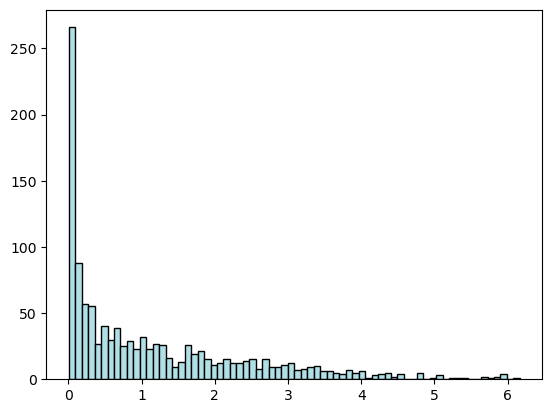

In [16]:
plot_loss_dist(test_output['loss_list'])

In [56]:
get_worst_loss_examples(test_output)

True Label:  Garnett
Pred Label:  Hogarth
Sample:  [CLS] Хозяйкой полною войди! [SEP] Its rightful mistress there to be. " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [58]:
get_best_loss_examples(test_output)

True Label:  Hogarth
Pred Label:  Hogarth
Sample:  [CLS] [UNK] Гм [UNK] да [UNK] так завтра. Деньги - то вы отдадите теперь? Я это, чтоб верно знать, [UNK] пробормотал он сконфузившись. [SEP] Yes, to - morrow, " he stammered. " Er by the way, would you mind handing me your contribution now, so as to make quite sure of it? " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Num Samples:  126


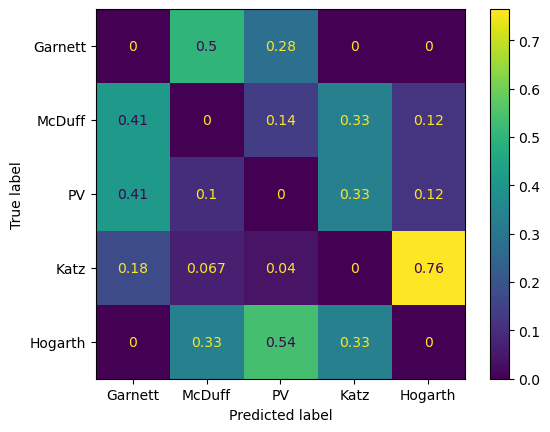

In [93]:
plot_loss_vs_labels(test_output['loss_list'], test_output['preds'], test_output['labels'])

### Eval Dataset

In [51]:
val_acc, val_loss, val_output = get_preds(model, data['val'])
print(f"Val accuracy: {val_acc:.4f}, Val loss: {val_loss:.4f}")

  0%|          | 0/98 [00:00<?, ?it/s]

Val accuracy: 0.5702, Val loss: 1.1390


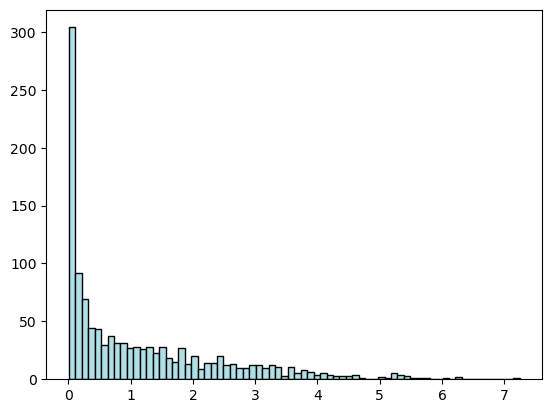

In [18]:
plot_loss_dist(val_output['loss_list'])

In [59]:
get_worst_loss_examples(val_output)

True Label:  Garnett
Pred Label:  McDuff
Sample:  [CLS] [UNK] Боже! Где вы нашли? Каким образом? [SEP] " Good God! Where, how did you find it?'[SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [60]:
get_best_loss_examples(val_output)

True Label:  Hogarth
Pred Label:  Hogarth
Sample:  [CLS] [UNK] Действительно, глупо, мы собрались в дружеской компании, чтоб проводить в вояж доброго приятеля, а вы считаетесь, [UNK] заговорил Трудолюбов, грубо обращаясь ко мне одному. [UNK] Вы к нам сами вчера напросились, не расстраивайте же общей гармонии [UNK] [SEP] Yes [UNK] and utter stupidity! " assented Trudoliubov. " We have met here to spend a few friendly hours together, and to wish our friend bon voyage ; yet you " [UNK] this was addressed to me exclusively [UNK] " must start quarrelling! Since you invited yourself to the dinner, pray do not disturb the general harmony at it. " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

Num Samples:  127


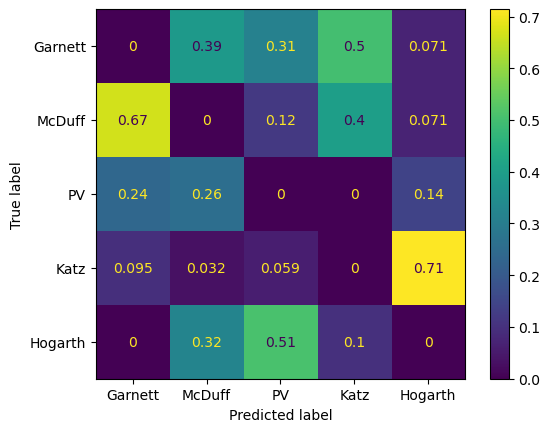

In [95]:
plot_loss_vs_labels(val_output['loss_list'], val_output['preds'], val_output['labels'])

### Train Dataset

In [52]:
train_acc, train_loss, train_output = get_preds(model, data['train'])
print(f"Train accuracy: {train_acc:.4f}, Val loss: {train_loss:.4f}")

  0%|          | 0/1478 [00:00<?, ?it/s]

Train accuracy: 0.8311, Val loss: 0.4209


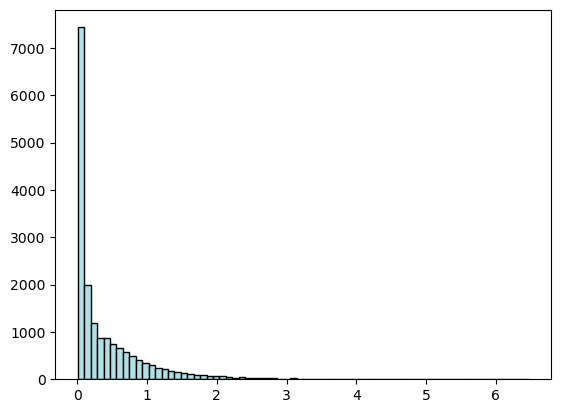

In [20]:
plot_loss_dist(train_output['loss_list'])

In [61]:
get_worst_loss_examples(train_output)

True Label:  PV
Pred Label:  Hogarth
Sample:  [CLS] « Ваше превосходительство! [SEP] Your Excellency, For by rank you are so. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [62]:
get_best_loss_examples(train_output)

True Label:  Hogarth
Pred Label:  Hogarth
Sample:  [CLS] [UNK] Итак, если нет препятствий, то с Богом можно бы приступить к совершению купчей крепости, [UNK] сказал Чичиков. [SEP] " So, " went on Chichikov, " if no obstacle stands in the way, we might as well proceed to the completion of the purchase. " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Num Samples:  162


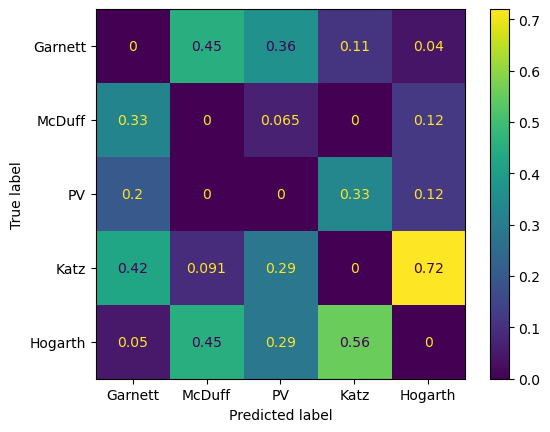

In [94]:
plot_loss_vs_labels(train_output['loss_list'], train_output['preds'], train_output['labels'])

## Tokenization Check

Compare text pre/post tokenization to figure out what the UNK tokens are

In [87]:
# Hogarth, "Что было делать? И туда было нельзя"
# Hogarth, "Мне кажется, об этом никто не вправе судить,"

train_df = pd.read_pickle(train_file) 
val_df = pd.read_pickle(val_file) 
test_df = pd.read_pickle(test_file) 

In [50]:
train_df.keys()

Index(['idx', 'book', 'labels', 'concat', 'translator', 'sim', 'src', 'tgt'], dtype='object')

In [54]:
train_df.head()

,idx,book,labels,concat,translator,sim,src,tgt
0,91,Demons,4,Из лицея молодой человек в первые два года при...,PV,0.976574,Из лицея молодой человек в первые два года при...,For the first two years the young man came hom...
1,1263,Demons,4,"– Вещь короткая; даже, если хотите, по-настоящ...",PV,0.976535,"– Вещь короткая; даже, если хотите, по-настоящ...","""It's a short matter; in fact, if you like, it..."
2,1228,Demons,4,– Да кто? Кто велел вам сюда приходить? – допр...,PV,0.976279,– Да кто? Кто велел вам сюда приходить? – допр...,"""But, who? Who told you to come here?"" Varvara..."
3,289,Demons,4,Так называемое у нас имение Степана Трофимович...,PV,0.976099,Так называемое у нас имение Степана Трофимович...,"Stepan Trofimovich's estate, as we used to cal..."
4,528,Demons,4,"– Шатов? Это брат Дарьи Павловны… <SEP> ""Shato...",PV,0.975940,– Шатов? Это брат Дарьи Павловны…,"""Shatov? He is Darya Pavlovna's brother..."""


In [52]:
hogarth_df = train_df.loc[train_df['translator'] == 'Hogarth']

In [47]:
hogarth_df.head()

,idx,book,concat,translator,sim,src,tgt,labels
2228,397,NotesFromUnderground,"—Это зачем?— спросила она. <SEP> ""And why?"" sh...",Hogarth,0.678752,—Это зачем?— спросила она.,"""And why?"" she inquired (she had heard, after ...",1
2074,254,NotesFromUnderground,Симонов вынул деньги и чуть не бросил их мне. ...,Hogarth,0.668201,Симонов вынул деньги и чуть не бросил их мне.,"Everything depends upon this — my future, my...",1
2253,334,NotesFromUnderground,"—Не из подвала, а из подвального этажа… ну зна...",Hogarth,0.725055,"—Не из подвала, а из подвального этажа… ну зна...","""Out of a cellar?"" "" Well, out of a basement y...",1
2341,57,NotesFromUnderground,Есть в воспоминаниях всякого человека такие ве...,Hogarth,0.941973,Есть в воспоминаниях всякого человека такие ве...,Every man’s reminiscences include things which...,1
2304,42,NotesFromUnderground,"И почему вы так твердо, так торжественно увере...",Hogarth,0.909598,"И почему вы так твердо, так торжественно увере...","Why, then, are you so absolutely, so portentou...",1


In [56]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
# tokenizer(tgt, 
#                         padding='max_length', 
#                         max_length=512, 
#                         truncation='longest_first',
#                         add_special_tokens=True
#                         )

# iterate thru dataframe rows
# tokenize src
# if src contains unk tokens, save pre-post, tokenized - [UNK]
# print

In [89]:
unk_1 = '–'
unk_2 = '’'
unk_3 = '…'
unk_4 = '—'
unk_5 = '“'
unk_6 = '”'

rep = '„'

for i, row in test_df.iterrows():
    src = row['src']
    tokenized_src = tokenizer(src, 
                        padding='max_length', 
                        max_length=512, 
                        truncation='longest_first',
                        add_special_tokens=True
                        )
    detokenized = tokenizer.decode(tokenized_src['input_ids'])
    
    if '[UNK]' in detokenized:
        print('here')
        if (unk_1 not in src) and (unk_2 not in src) and (unk_3 not in src) and (unk_4 not in src) and (unk_5 not in src) and (unk_6 not in src):
            print('Pre-tokenization: ', src)
            print('Post-tokenization: ', detokenized)
            print()
        # if i == 500:
        #     break

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [93]:
for i, row in test_df.iterrows():
    src = row['src']
    if (unk_1 in src) or (unk_2 in src) or (unk_3 in src) or (unk_4 in src) or (unk_5 in src) or (unk_6 in src):
        print('here')
        src_clean = src.replace('–', "-").replace('’', '\'').replace('…','...').replace('—', '-').replace('“', "\"").replace('”', "\"").replace('„', '\"')
        
        test_df.loc[i, 'src'] = src_clean
        test_df.loc[i, 'concat'] = src_clean + ' <SEP> ' + test_df.loc[i, 'tgt']
        
        # print('Pre-tokenization: ', src)
        # print('Post-tokenization: ', src_clean)
        # print()
            
        tokenized_src = tokenizer(src_clean, 
                            padding='max_length', 
                            max_length=512, 
                            truncation='longest_first',
                            add_special_tokens=True
                            )
        detokenized = tokenizer.decode(tokenized_src['input_ids'])
        
        if '[UNK]' in detokenized:
            print('Pre-tokenization: ', src)
            print('Post-tokenization: ', detokenized)
            print()
        # row['concat']

In [97]:
# dataset dirs
dir = "/home/kkatsy/litMT/"
dataset_dir = dir + "experiment_dataset/"
aligned_train_file = dataset_dir + 'original/aligned_train_df.pickle'
random_train_file = dataset_dir + 'original/random_train_df.pickle'

train_file = aligned_train_file if alignment=='aligned' else random_train_file
val_file = dataset_dir + 'original/experiment_val_df.pickle'
test_file = dataset_dir + 'original/experiment_test_df.pickle'

In [110]:
# clean saved data
new_dir = '4class_diff_holdout_clean/'
dir = '4class_diff_holdout/'
print(dataset_dir + dir)
for filename in os.listdir(dataset_dir + dir):
    f = os.path.join(dataset_dir, dir, filename)
    # checking if it is a file
    print(f)
    if os.path.isfile(f):
        print(f)
        df = pd.read_pickle(f)
        for i, row in df.iterrows():
            src = row['src']
            if (unk_1 in src) or (unk_2 in src) or (unk_3 in src) or (unk_4 in src) or (unk_5 in src) or (unk_6 in src):
                print('here')
                src_clean = src.replace('–', "-").replace('’', '\'').replace('…','...').replace('—', '-').replace('“', "\"").replace('”', "\"").replace('„', '\"')
                
                df.loc[i, 'src'] = src_clean
                df.loc[i, 'concat'] = src_clean + ' <SEP> ' + df.loc[i, 'tgt']
                
        f_name = f.split('/')[-1]
        dest = dataset_dir + new_dir + f_name
        print(dest)
        df.to_pickle(dest) 

/home/kkatsy/litMT/experiment_dataset/4class_diff_holdout/
/home/kkatsy/litMT/experiment_dataset/4class_diff_holdout/4class_experiment_test_df.pickle
/home/kkatsy/litMT/experiment_dataset/4class_diff_holdout/4class_experiment_test_df.pickle
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

In [108]:
df = pd.read_pickle('/home/kkatsy/litMT/experiment_dataset/original_clean/random_train_df.pickle') 

unk_1 = '–'
unk_2 = '’'
unk_3 = '…'
unk_4 = '—'
unk_5 = '“'
unk_6 = '”'

rep = '„'

for i, row in test_df.iterrows():
    src = row['src']
    tokenized_src = tokenizer(src, 
                        padding='max_length', 
                        max_length=512, 
                        truncation='longest_first',
                        add_special_tokens=True
                        )
    detokenized = tokenizer.decode(tokenized_src['input_ids'])
    
    if '[UNK]' in detokenized:
        print('here')
        if (unk_1 not in src) and (unk_2 not in src) and (unk_3 not in src) and (unk_4 not in src) and (unk_5 not in src) and (unk_6 not in src):
            print('Pre-tokenization: ', src)
            print('Post-tokenization: ', detokenized)
            print()